In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [0]:
from torch.utils.data.dataset import Dataset
from torch.distributions.categorical import Categorical
from PIL import Image

class ImageConverter(Dataset):
  def __init__(self, data, transform):
    self.distribution = Categorical(torch.tensor([0.25, 0.25, 0.25, 0.25]))
    self.transform = transform
    self.X = data 
    self.y = rot_labels(data.shape[0], self.distribution)
  def __getitem__(self, index):
    x = self.X[index]
    x = apply_rot(x, self.y[index])
    x = x.reshape(1, x.shape[0], x.shape[1])
    x = x.repeat(3, 1, 1)
    x = self.transform(x)
    i = int(self.y[index].item())
    y_t = [0, 0, 0, 0]
    y_t[i] = 1
    return x.to(dtype=torch.float), torch.Tensor(y_t) 
  def __len__(self):
    return self.X.shape[0]
    
    

In [0]:
def apply_rot(x, y):
  if y == 3: 
    x = x.flip(1).t()
  elif y == 2: 
    x = x.flip(0).flip(1)
  elif y == 1:
     x = x.t().flip(1)
  return x

def rot_labels(length, dist):
  return torch.Tensor([dist.sample() for x in range(0, length)])

In [0]:
import torchvision
import torchvision.transforms as transforms
import numpy as np

batch_size = 256
image_dim = 784
img_size = 224


#!rm -r data/

transf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
    ])


train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                download=True, transform=None)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                download=True, transform=None)


train_all = ImageConverter(train_dataset.train_data, transf)
test_all = ImageConverter(test_dataset.test_data, transf)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [0]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): None
    Target Transforms (if any): None

In [0]:
def get_loaders():
    valid_size=0.2
    random_seed = 32
    shuffle = True
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
   
    
    train_loader = torch.utils.data.DataLoader(train_all,
                          batch_size=256,
                          num_workers=1,
                          sampler=train_sampler
                         )

    valid_loader = torch.utils.data.DataLoader(train_all,
                          batch_size=256,
                          num_workers=1,
                          sampler=valid_sampler
                         )   
    
    test_loader = torch.utils.data.DataLoader(test_all,
                          batch_size=256,
                          shuffle=True,
                          num_workers=1,
                         )   
    return train_loader, valid_loader, test_loader
  
  
train_loader, valid_loader, test_loader = get_loaders() 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


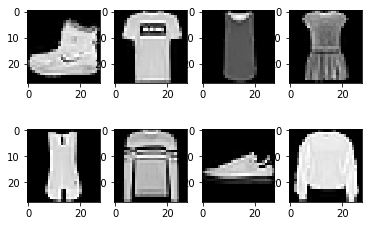

torch.Size([60000, 28, 28])


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    plt.imshow(train_dataset.train_data[i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

print(train_dataset.train_data.shape)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import numpy as np

class MLP(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(MLP, self).__init__()
      self.fc = nn.Linear(input_dim, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, output_dim)
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()
      
    def forward(self, x):
      fc = self.fc(x)
      fc2 = self.fc2(self.relu(fc))
      return self.sigmoid(fc2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(torch.nn.Module):
  
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 14 * 14, 64)
        self.fc2 = torch.nn.Linear(64, 4)
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.sig(self.fc2(x))
        return(x)

In [0]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = nn.Linear(4096, 4)


In [0]:
!pip install torchbearer

import torchbearer
from torchbearer import Trial
from torchbearer.callbacks.decorators import on_end_epoch
from torch import optim


model = alexnet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-3)
  
def sigcross(x, y):
  return F.binary_cross_entropy(torch.sigmoid(x), y, size_average=False) / x.shape[0]
  
 
torchbearer_trial = Trial(model, optimizer, criterion=sigcross,  metrics=['loss']).to(device)
torchbearer_trial.with_generators(train_generator=train_loader, val_generator=valid_loader, test_generator=test_loader)
torchbearer_trial.run(epochs=5)
torchbearer_trial.predict()

     |████████████████████████████████| 92kB 4.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/6c/cb/69/466aef9cee879fb8f645bd602e34d45e754fb3dee2cb1a877a
Successfully built torchbearer


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor([[-16.0628,  13.1551, -14.8174, -15.2505],
        [-16.1166,  10.2681, -14.7915, -11.2555],
        [-10.4275, -10.7086, -11.0334,   8.5952],
        ...,
        [-13.9707,  10.1041, -12.4816, -11.2499],
        [  9.6380, -12.1704, -10.4938, -14.2633],
        [ -6.6123,  -5.1823,  -9.1731,   5.2750]], device='cuda:0')

In [0]:
images, labels = iter(test_loader).next()

In [0]:
model.eval()
output = model(images.to(device))
predictions = []
label = []
for i, x in enumerate(output.detach().cpu()):
  predictions.append(np.argmax(x))
  label.append(np.argmax(labels[i]))

In [0]:
total = 0
count = 0
incorrect = []
for i, x in enumerate(predictions):
  if x == label[i]: 
    count+=1
  else: 
    incorrect.append(i)
  total+=1

print(count/total)
  

0.97265625


In [0]:
incorrect

[22, 24, 56, 90, 169, 190, 228]

torch.Size([224, 224])
Actual Label: 0
Predicted Label: 0


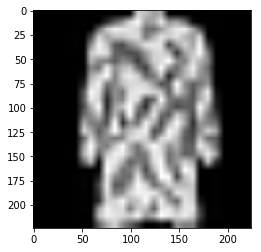

In [0]:
print(images[3][0].shape)

index = 238

plt.imshow(images[index][0], cmap=plt.get_cmap('gray'))
print("Actual Label:", label[index].item())
print("Predicted Label:", predictions[index].item())

In [0]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


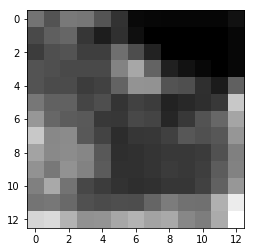

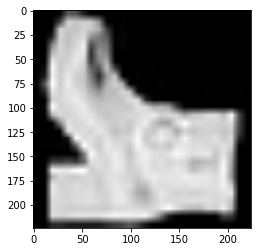

In [0]:
activation = {}
ind= 34
model.features[5].register_forward_hook(get_activation('3'))
x = images[ind].reshape(1, 3, 224, 224)
output = model(x.to(device))
heatmap = torch.mean(activation['3'], dim=1).squeeze()
heatmap = np.maximum(heatmap.cpu(), 0)
heatmap /= torch.max(heatmap.cpu())
plt.imshow(heatmap.cpu(), cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(x[0][0], cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p